In [13]:
import pandas as pd
import os
import numpy as np
import torch as t
import matplotlib.pylab as pl

In [14]:
TRAINING_PATH = './crime-train.txt'
TEST_PATH = './crime-test.txt'
df_train = pd.read_table(TRAINING_PATH)
df_test = pd.read_table(TEST_PATH)
print df_train.head()
print df_test.head()

   ViolentCrimesPerPop  population  householdsize  agePct12t21  agePct12t29  \
0                 0.67       -0.45          -1.85        -1.06         0.67   
1                 0.43       -0.45          -0.27        -0.22        -0.17   
2                 0.12       -0.14           1.87         0.55         0.04   
3                 0.03       -0.38           0.53        -0.28        -0.79   
4                 0.14       -0.30          -1.12        -0.74        -0.10   

   agePct16t24  agePct65up  numbUrban  pctUrban  medIncome  \
0         0.08       -0.85      -0.34      0.68      -0.24   
1        -0.34       -0.58      -0.50     -1.57      -0.29   
2         0.02       -1.19      -0.03      0.68       1.05   
3        -0.64       -0.35      -0.34      0.46       0.66   
4        -0.40       -0.30      -0.19      0.68       0.76   

          ...           NumStreet  PctForeignBorn  PctBornSameState  \
0         ...               -0.23           -0.02             -0.53   
1         

In [15]:
y_train, X_train = df_train.values[:,0].reshape(-1,1), df_train.values[:,1:]
y_test, X_test = df_test.values[:,0].reshape(-1,1), df_test.values[:,1:]
print 'load training data:\n X_train: {}\n y_train: {}'.format(
    X_train.shape, y_train.shape)
print 'load test data:\n X_test: {}\n y_test: {}'.format(
    X_test.shape, y_test.shape)

load training data:
 X_train: (1595, 95)
 y_train: (1595, 1)
load test data:
 X_test: (399, 95)
 y_test: (399, 1)


In [16]:
# add one col as bias
X_train = np.hstack((np.ones(X_train.shape[0]).reshape(-1,1), X_train))
X_test = np.hstack((np.ones(X_test.shape[0]).reshape(-1,1), X_test))
print X_train.shape, X_test.shape

(1595, 96) (399, 96)


In [17]:
def loss_gradient(X, y, W, reg, Is_train=True):
    '''Input: 
            X: training data, shape is (N, D+1), the extra one dimenstion is use to add bias, all equal to 1
            y: training data, shape is (N, 1)
            W: weight, shape is (D+1, 1), the extra one dimenstion is bias b
            reg: L2 regularization strength, is a hyperparameter
            Is_train: get loss without regularization 
       Output:
            loss: scala
            dW: shape as W
    '''
    N, D = X.shape
    y_pred = X.dot(W)
    loss = 0.5 * np.sum((y - y_pred)**2)
    if Is_train == True:
        loss += reg * np.sum(W**2)
        dW = -X.T.dot(y - y_pred) 
        dW += 2 * reg * W
        return loss, dW
    else:
        return loss

def train_LS(X, y, learning_rate, reg, num_iters, stop, batch_size, verbose=False):
    N, D = X.shape
    # initialize W
    W = 0.001 * np.random.randn(D, 1)
    # save loss 
    loss_history = []
    
    for it in range(num_iters):
        
        mask = np.random.choice(N, batch_size)
        X_batch = X[mask]
        y_batch = y[mask]
        
        loss, dW = loss_gradient(X_batch, y_batch, W, reg)
#         print loss.shape
        loss_history.append(float(loss))
        # update W
        delta_W = -learning_rate*dW
        W += delta_W
        # verbose
        if verbose and it % 1000 == 0:
            print 'iteration %d / %d: loss %f' % (it, num_iters, loss)
#         print np.linalg.norm(dW)
        if np.max(abs(delta_W)) < stop:
            break
    return loss_history, W

In [18]:
def K_folds_idx(X_train, K):
    N = X_train.shape[0]
    pos = N/K
    idices = np.array(range(N))
    folds = []
    for i in range(K):
        start = i * pos
        end = start + pos
        left_idx, mid_idx, right_idx = np.split(idices, [start, end])
        train_idx = np.append(left_idx, right_idx)
        folds.append((train_idx, mid_idx))
    return folds

In [19]:
# from sklearn.model_selection import StratifiedKFold
# K=10
# folds = list(StratifiedKFold(n_splits=K, 
#                              shuffle=True, 
#                              random_state=16).split(X_train, y_train))
learning_rate = 0.00001
# reg = 0.01
regs = [10**i for i in range(-6, 3)]
num_iters = 3000
stop = 7e-5
threshold = 1e-8

K = 10
folds = K_folds_idx(X_train, K)
best_reg = None
best_W_all = None
best_r2 = 0
best_test_loss = None
results_train = []
results_test = []
num_small_coefs = []

for reg in regs:
    print '==================================regularizzation strength: ', reg
    best_W = None
    best_val_loss = 1000
    for j, (train_idx, val_idx) in enumerate(folds):
        print('\n==============================FOLD=',j)
        X_train_cv = X_train[train_idx]
        y_train_cv = y_train[train_idx]
        X_val = X_train[val_idx]
        y_val= y_train[val_idx]

        batch_size = X_train_cv.shape[0]
        loss_history, W = train_LS(X=X_train_cv, 
                                   y=y_train_cv,
                                   learning_rate = learning_rate, 
                                   reg = reg, 
                                   num_iters = num_iters, 
                                   stop = stop, 
                                   batch_size = batch_size, 
                                   verbose=True)
        val_loss = loss_gradient(X_val, y_val, W, reg, Is_train=False)
        print 'Train loss: ', loss_history[-1]
        print 'Validation loss: ', val_loss
        if best_val_loss > val_loss:
            best_val_loss = val_loss
            best_W = W
    y_p = X_train.dot(best_W)
    # number of small coefficients
    num_small_coef = np.argwhere(best_W < threshold).shape[0]
    num_small_coefs.append(num_small_coef)
    
    from sklearn.metrics import r2_score
    r2 = r2_score(y_train.reshape(-1), y_p.reshape(-1))
    print '======================================R-square score: ', r2
    
    train_loss = loss_gradient(X_train, y_train, best_W, reg, Is_train=False)
    test_loss = loss_gradient(X_test, y_test, best_W, reg, Is_train=False)
    if best_test_loss is None or best_test_loss > test_loss:
        best_r2 = r2
        best_reg = reg
        best_W_all = best_W
        best_test_loss = test_loss
    results_train.append(train_loss)
    results_test.append(test_loss)

==================================regularizzation strength:  1e-06
('\n==============================FOLD=', 0)
iteration 0 / 3000: loss 76.622273
Train loss:  12.0914400072
Validation loss:  1.6533746347351796
('\n==============================FOLD=', 1)
iteration 0 / 3000: loss 80.153524
Train loss:  11.3707597592
Validation loss:  1.6569767742042398
('\n==============================FOLD=', 2)
iteration 0 / 3000: loss 75.187871
Train loss:  11.1417199954
Validation loss:  1.854091266377026
('\n==============================FOLD=', 3)
iteration 0 / 3000: loss 81.197302
iteration 1000 / 3000: loss 12.074191
Train loss:  10.7691529876
Validation loss:  1.2477571434034913
('\n==============================FOLD=', 4)
iteration 0 / 3000: loss 77.594928
Train loss:  11.17890897
Validation loss:  1.7946763409514912
('\n==============================FOLD=', 5)
iteration 0 / 3000: loss 80.486240
Train loss:  12.3379421329
Validation loss:  1.139670958488039
('\n==============================F

iteration 1000 / 3000: loss 11.505329
Train loss:  11.8771600646
Validation loss:  1.3356919913025078
('\n==============================FOLD=', 9)
iteration 0 / 3000: loss 88.375040
Train loss:  12.2689200546
Validation loss:  1.320260625298712
======================================R-square score:  0.6771335216891108
==================================regularizzation strength:  0.1
('\n==============================FOLD=', 0)
iteration 0 / 3000: loss 79.338023
Train loss:  10.8974808359
Validation loss:  1.6582476945991216
('\n==============================FOLD=', 1)
iteration 0 / 3000: loss 80.280198
Train loss:  11.8507652595
Validation loss:  1.6710283666381247
('\n==============================FOLD=', 2)
iteration 0 / 3000: loss 82.797246
iteration 1000 / 3000: loss 12.671759
Train loss:  11.6464402533
Validation loss:  1.8485298366268572
('\n==============================FOLD=', 3)
iteration 0 / 3000: loss 84.170989
iteration 1000 / 3000: loss 13.280221
Train loss:  11.4739021854
V

######################### Question 1 ######################


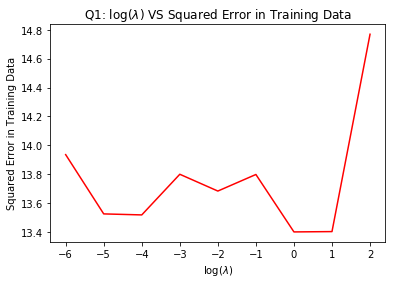

In [24]:
print "######################### Question 1 ######################"
pl.plot(np.log(np.asarray(regs))/np.log(10), results_train, 'r-')
pl.xlabel('log$(\lambda)$')
pl.ylabel('Squared Error in Training Data')
pl.title('Q1: log$(\lambda)$ VS Squared Error in Training Data')
pl.show()

######################### Question 2 ######################


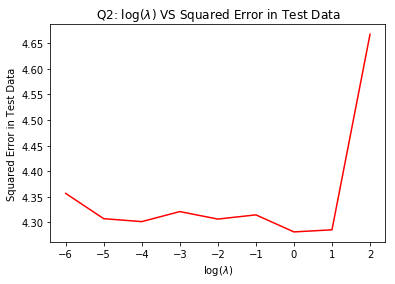

In [25]:
print "######################### Question 2 ######################"
pl.plot(np.log(np.asarray(regs))/np.log(10), results_test, 'r-')
pl.xlabel('log$(\lambda)$')
pl.ylabel('Squared Error in Test Data')
pl.title('Q2: log$(\lambda)$ VS Squared Error in Test Data')
pl.show()

######################### Question 3 ######################


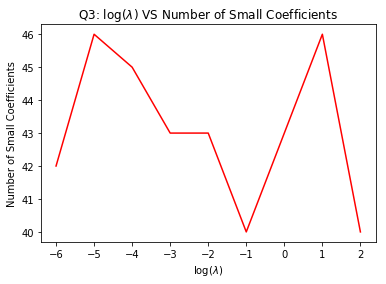

In [26]:
print "######################### Question 3 ######################"
pl.plot(np.log(np.asarray(regs))/np.log(10), num_small_coefs, 'r-')
pl.xlabel('log$(\lambda)$')
pl.ylabel('Number of Small Coefficients')
pl.title('Q3: log$(\lambda)$ VS Number of Small Coefficients')
pl.show()

In [27]:
print "######################### Question 4 ######################"
print "The best test set proformance: lambda = {}, test loss = {}".format(best_reg, best_test_loss)
print "The largest coefficient: ", best_W_all.max()
print "The smallest coefficient: ", best_W_all.min()

######################### Question 4 ######################
The best test set proformance: lambda = 1, test loss = 4.28144288365
The largest coefficient:  0.23422336250165984
The smallest coefficient:  -0.045206631988225505
